# Multimodal Search

In this project, we will learn how to use vector databases to search through images using natural language.

We will be searching through an open source image dataset using an open source model called CLIP.
This model is able to encode both images and text into the same embedding space, allowing us to retrieve images that are similar to a user question.

In [ ]:

!pip install --quiet datasets gradio lancedb pandas transformers

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.8/34.8 MB 25.4 MB/s eta 0:00:00


## Setup CLIP model

First, let's prepare the [CLIP](https://huggingface.co/docs/transformers/model_doc/clip) model to encode the images.
We want to setup two things:
1. a model to encode the image
2. a processor to prepare the image to be encoded



By reading the CLIP documentation, we see that we can use the `from_pretrained` classmethods to initialize the model and the processor

In [ ]:
from transformers import CLIPModel, CLIPProcessor

MODEL_ID = "openai/clip-vit-base-patch32"

device = "cpu"

model = CLIPModel.from_pretrained(MODEL_ID).to(device)
processor = CLIPProcessor.from_pretrained(MODEL_ID)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/605M [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

## Setup data model

The dataset itself has an image field and an integer label.
We'll also need an embedding vector (CLIP produces 512D vectors) field.

For this project, field named "vector" to the Image class below that is a 512D vector.

The image that comes out of the raw dataset is a PIL image. So we'll add some conversion code between PIL and bytes to make it easier for serde.

In [ ]:
import io

from lancedb.pydantic import LanceModel, vector
import PIL

class Image(LanceModel):
    image: bytes
    label: int
    vector: vector(512)

    def to_pil(self):
        return PIL.Image.open(io.BytesIO(self.image))

    @classmethod
    def pil_to_bytes(cls, img) -> bytes:
        buf = io.BytesIO()
        img.save(buf, format="PNG")
        return buf.getvalue()

## Image processing function

Next we will implement a function to process batches of data from the dataset.
We will be using the `zh-plus/tiny-imagenet` dataset from huggingface datasets.
This dataset has an `image` and a `label` column.

We extract image embeddings from
the image using the CLIP model.

Here we'll use the `get_image_features` method on the model instance

In [ ]:
def process_image(batch: dict) -> dict:
    image = processor(text=None, images=batch["image"], return_tensors="pt")[
        "pixel_values"
    ].to(device)
    img_emb = model.get_image_features(image)
    batch["vector"] = img_emb.cpu()
    batch["image_bytes"] = [Image.pil_to_bytes(img) for img in batch["image"]]
    return batch

## Table creation
We create a LanceDB table called `image_search` to store the image, label, and vector.

Let's call `lancedb.connect` then
`db.create_table`

In [ ]:
import lancedb

db = lancedb.connect("~/.lancedb")
TABLE_NAME = "image_search"
db.drop_table(TABLE_NAME, ignore_missing=True)
table = db.create_table(TABLE_NAME, schema=Image.to_arrow_schema())

## Adding data

Now we're ready to process the images and generate embeddings.
We write a function called `datagen` that calls `process_image` on each image in the validation set (10K images) and return a list of Image instances.


1. We may find it faster to use the [dataset.map](https://huggingface.co/docs/datasets/process#map) function.
2. We'll want to store the `image_bytes` field that is returned by `process_image`.
3. We'll call `load_dataset` and retrieve the `valid` split
4. We then map `process_image` and construct Image instances

In [ ]:
from datasets import load_dataset

def datagen() -> list[Image]:
    dataset = load_dataset("zh-plus/tiny-imagenet")['valid']
    return [Image(image=b["image_bytes"],
                 label=b["label"],
                 vector=b["vector"])
           for b in dataset.map(process_image, batched=True, batch_size=64)]

Now we call the function we just wrote and add the generated instances to the LanceDB table. The following process can take up to 60 minutes to complete.

In [ ]:
data = datagen()
table.add(data)

README.md: 0.00B [00:00, ?B/s]

dataset_infos.json: 0.00B [00:00, ?B/s]

(…)-00000-of-00001-1359597a978bc4fa.parquet:   0%|          | 0.00/146M [00:00<?, ?B/s]

(…)-00000-of-00001-70d52db3c749a935.parquet:   0%|          | 0.00/14.6M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/100000 [00:00<?, ? examples/s]

Generating valid split:   0%|          | 0/10000 [00:00<?, ? examples/s]

/usr/local/lib/python3.11/dist-packages/dill/_dill.py:414: PicklingWarning: Cannot locate reference to <class '__main__.Image'>.
  StockPickler.save(self, obj, save_persistent_id)
/usr/local/lib/python3.11/dist-packages/dill/_dill.py:414: PicklingWarning: Cannot pickle <class '__main__.Image'>: __main__.Image has recursive self-references that trigger a RecursionError.
  StockPickler.save(self, obj, save_persistent_id)
/usr/local/lib/python3.11/dist-packages/dill/_dill.py:414: PicklingWarning: Cannot locate reference to <class '__main__.ColabKernelApp'>.
  StockPickler.save(self, obj, save_persistent_id)
/usr/local/lib/python3.11/dist-packages/dill/_dill.py:414: PicklingWarning: Cannot pickle <class '__main__.ColabKernelApp'>: __main__.ColabKernelApp has recursive self-references that trigger a RecursionError.
  StockPickler.save(self, obj, save_persistent_id)
Parameter 'function'=<function process_image at 0x7faaf258a660> of the transform datasets.arrow_dataset.Dataset._map_single cou

Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

AddResult(version=2)

## Encoding user queries

We have image embeddings, but how do we generate the embeddings for the user query?
Furthermore, how can we possibly have the same features between the image embeddings
and text embeddings. This is where the power of CLIP comes in.

We write a function to turn user query text into an embedding
in the same latent space as the images.

**NOTE**
We refer to the [CLIPModel documention](https://huggingface.co/docs/transformers/model_doc/clip#transformers.CLIPModel)

In [ ]:
from transformers import CLIPTokenizerFast

model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
tokenizer = CLIPTokenizerFast.from_pretrained(MODEL_ID)

def embed_func(query):
    inputs = tokenizer([query], padding=True, return_tensors="pt")
    text_features = model.get_text_features(**inputs)
    return text_features.detach().numpy()[0]

## Core search function

Now we write the core search function `find_images`, that takes a text query as input, and returns a list of PIL images that's most similar to the query.


First, we need to call `embed_func` on the query to generate the text embedding.
Then, we'll search through the LanceDB to get images most similar to the query.
And we'll convert the resrults into Image instances.
Finally, we'll call the `Image.to_pil` method to convert the bytes into PIL images

In [ ]:
def find_images(query):
    emb = embed_func(query)
    rs = table.search(emb).limit(9).to_pydantic(Image)
    return [m.to_pil() for m in rs]

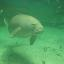

In [ ]:
find_images("fish")[0]

In [ ]:
import nbformat

path = "cleaned_notebook.ipynb"

# Get the current notebook contents
from google.colab import _message
nb = _message.blocking_request('get_ipynb')['ipynb']

# Remove 'widgets' metadata if present
if 'widgets' in nb['metadata']:
    del nb['metadata']['widgets']

# Save the cleaned notebook
with open(path, "w") as f:
    nbformat.write(nbformat.from_dict(nb), f)

print(f"Cleaned notebook saved as {path}")